# **SpamClassifier**

#### Жёстко обучаем LSTM на классификацию спама на английском

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Короче, там куча всякого мусора, поэтому оставим только столбцы v1 и v2.

In [3]:
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
target = 'v1'
feature = 'v2'

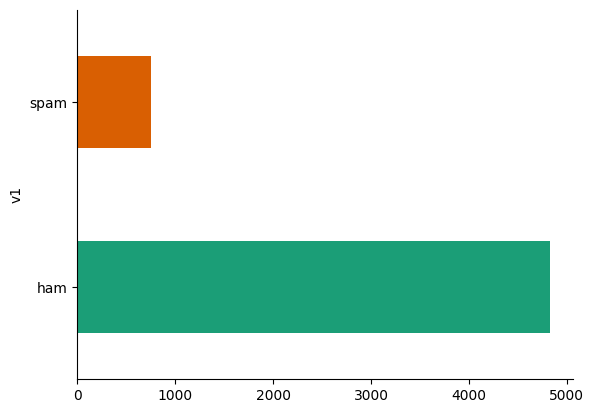

In [5]:
# @title Распределение спама и не спама

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('v1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# Warning! Don't run this cell twice!
df[target] = df[target].apply(lambda x: 1 if x == 'spam' else 0)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Посчитаем максимальную длину текста в описании. Зачем? Пусть будет.

In [7]:
max_words = 0
for desc in df[feature]:
  words = len(desc.split())
  if words > max_words:
    max_words = words

f'Max message body length: {max_words} words'

'Max message body length: 171 words'

Токенизируем тексты сообщений, превратив слова в чиселки:

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[feature].tolist())

textSequences = tokenizer.texts_to_sequences(df[feature].tolist())

Разобьём выборку на тренировочную и тестовую (за типизацию не бейте по рукам только):

In [9]:
def load_data_from_arrays(strings, labels, train_size=0.8):
  data_size = len(strings)
  test_size = int(data_size - round(data_size * train_size))
  print(f"Test size: {test_size}")

  print("\nTraining set:")
  x_train = strings[test_size:]
  print(f"\t - x_train: {x_train}")
  y_train = labels[test_size:].values
  print(f"\t - y_train: {y_train}")

  print("\nTesting set:")
  x_test = strings[:test_size]
  print(f"\t - x_test: {x_test}")
  y_test = labels[:test_size].values
  print(f"\t - y_test: {y_test}")

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data_from_arrays(textSequences, df[target], train_size=0.8)

Test size: 1114

Training set:
	 - x_train: [[38, 38, 40, 9, 1369, 77, 2660, 5310, 77, 468, 9, 3516], [23, 672, 138, 14, 725, 26, 1000, 72, 234, 5311], [127, 53, 63, 9, 13, 563, 18, 783, 39, 50, 12, 5312, 18, 783], [5313, 3, 17, 182, 4, 881, 441, 507, 2, 124, 16, 5314], [30, 75, 42, 285, 21, 470, 11, 579, 57, 635, 332, 1, 50, 1940, 19, 981, 82], [550, 15, 2661, 707, 278, 3517, 73, 3517, 2, 5315, 34, 3, 98, 55, 1076, 73, 5316, 7, 31, 4, 101, 5317, 5318, 1755, 187, 128, 5319, 259], [1308, 5320, 7, 31, 115, 226, 87], [27, 3, 70, 670, 743, 105, 438, 280, 1163, 71, 7, 4, 101, 378, 110, 12, 64, 1607, 633, 234, 112, 16, 3518, 21, 26, 92, 12, 560, 151], [46, 46, 46, 57, 692, 35, 591, 402], [56, 171, 410, 49, 22, 3], [2164, 83, 82, 397, 19, 99, 6], [12, 666, 419, 8, 91, 96, 3519, 522, 3, 28, 21, 17, 528, 463, 19, 277, 1237, 3, 256, 19, 31, 871, 37, 68, 73, 2, 5321, 179, 140, 141, 5322, 188, 117, 1271], [25, 231, 837, 2662, 44, 18, 115, 239, 40, 9, 11, 101, 146, 76, 5, 139], [2098, 15, 123, 361,

Дополним последовательности чисел нулями, чтоб был одинаковый размер:

In [10]:
from keras.utils import pad_sequences

x_train = pad_sequences(x_train, maxlen=max_words, padding='post')
x_test = pad_sequences(x_test, maxlen=max_words, padding='post')

Данные обработали, погнали теперь обучаться

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

total_unique_words = len(tokenizer.word_counts)

model = Sequential()
model.add(Embedding(total_unique_words + 1, max_words))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 171)         1525491   
                                                                 
 lstm (LSTM)                 (None, 32)                26112     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1551636 (5.92 MB)
Trainable params: 1551636 (5.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
batch_size = 50
epochs = 1

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

90/90 [==============================] - 37s 351ms/step - loss: 0.4107 - accuracy: 0.8701 - val_loss: 0.4262 - val_accuracy: 0.8492


In [13]:
model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

23/23 [==============================] - 2s 92ms/step - loss: 0.4262 - accuracy: 0.8492


[0.42623767256736755, 0.8491920828819275]